In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model

In [11]:
# Load video and split in 30 frames
def load_video(video_id, num_frames=30):
    
    video_folder = 'AlgonautsVideos268_All_30fpsmax'
    # Ensure the video folder exists
    if not os.path.exists(video_folder):
        print(f"The folder {video_folder} does not exist.")
        return None
    
    else:
        video_path = None
        # List all mp4 files in the video folder
        for file_name in os.listdir(video_folder):
            if file_name.endswith('.mp4') and file_name.startswith(video_id):
                video_path = os.path.join(video_folder, file_name)
                break  # Stop searching once the first match is found
        
        if video_path:
            print(f"Video path: {video_path}")
        else:
            print(f"No video found for video_id: {video_id}")
            return None
            
    # Capture video
    vidcap = cv2.VideoCapture(video_path)
    # Determine the total number of frames in the video
    total_frames = int(vidcap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Calculate the interval for frame sampling
    frame_interval = max(1, total_frames // num_frames)
    
    frames = []  # List to store selected frames
    count = 0  # Frame counter

    # Use a while loop to read frames from the video
    while True:
        success, frame = vidcap.read()
        
        # Break the loop if there are no more frames
        if not success:
            break

        # Sample frames based on the calculated interval
        if count % frame_interval == 0 and len(frames) < num_frames:
            frames.append(frame)
        
        # Break the loop if we have collected the desired number of frames
        if len(frames) == num_frames:
            break

        count += 1

    # Release the video capture object
    vidcap.release()

    # Convert the list of frames to a numpy array for convenience if required
    # frames = np.array(frames)
    return frames

In [12]:
# frames = load_video('0001')
# len(frames)
# print(frames[0].shape)

In [13]:
def extract_features_single_frame(frame, models):
    """
    Extract features from a single preprocessed frame using specified models.
    
    Parameters:
    - preprocessed_frame: A single preprocessed frame (as a numpy array).
    - models: Dictionary of Keras models for feature extraction at specified stages.
    
    Returns:
    - Dictionary of features extracted by each model.
    """
    # Preprocess frames for resnet50
    frame = cv2.resize(frame, (224,224))
    if len(frame.shape) == 3:
        frame = np.expand_dims(frame, axis=0)
    frame = preprocess_input(frame)
    
    # Initialize a dictionary to hold features from each stage
    features_per_stage = {}
    
    # Extract and store features for each stage
    for stage, model in models.items():
        stage_features = model.predict(frame)
        features_per_stage[stage] = stage_features
    
    return features_per_stage

In [14]:
# features = extract_features_single_frame(frames[0], models)

In [15]:
# # Assuming 'features' is the dictionary returned by the extract_features_single_frame function
# for stage, feature_map in features.items():
#     print(f"{stage}: {feature_map.shape}")

In [16]:
def plot_frame_with_feature_map_overlay(video_id, frame_number, stage, models, pooling_method='avg'):
    """
    Plots a frame overlaid by its corresponding pooled feature map for a specified stage.

    Parameters:
    - video_id: The ID of the video.
    - frame_number: The frame number to extract features from and plot (1-based indexing).
    - stage: The stage from which to visualize the feature map.
    - models: The models used for feature extraction, keyed by stage.
    """
    # Step 1: Load the video and select a single frame
    frames = load_video(video_id, num_frames=30)
    selected_frame = frames[frame_number - 1]  # Adjust for 0-based indexing
    print(f"Selected frame shape: {selected_frame.shape}")
    
    # Step 2: Extract features for the selected frame
    features = extract_features_single_frame(selected_frame, models)
    feature_map = features[stage]  # Extract the feature map for the specified stage
    
    # Pool the feature map over filters (channels)
    if pooling_method == 'avg':
        pooled_feature_map = np.mean(feature_map, axis=-1)[0]  # [0] to select the first image if batched
    elif pooling_method == 'max':
        pooled_feature_map = np.max(feature_map, axis=-1)[0]
    else:
        raise ValueError("Invalid pooling method. Please choose 'avg' or 'max'.")
    
    # Resize the pooled feature map to match the frame size (224, 224)
    resized_pooled_feature_map = cv2.resize(pooled_feature_map, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # Step 3: Overlay the feature map on the original frame
    # Ensure the original frame is resized to 224x224 for overlay compatibility
    resized_frame = cv2.resize(selected_frame, (224, 224), interpolation=cv2.INTER_LINEAR)
    
    # Normalize and convert the feature map to a colormap for visualization
    normalized_feature_map = cv2.normalize(resized_pooled_feature_map, None, 0, 255, cv2.NORM_MINMAX)
    colored_feature_map = cv2.applyColorMap(normalized_feature_map.astype(np.uint8), cv2.COLORMAP_JET)
    
    # Adjust these values to change the visibility of the original frame
    alpha = 0.75  # Increase alpha to make the original picture more visible
    beta = 0.25   # Decrease beta to make the feature map less prominent
    gamma = 0    # Usually kept as 0 to not bias brightness and contrast
    
    # Overlay the feature map on the frame with adjusted weights
    overlay_image = cv2.addWeighted(resized_frame.astype(np.uint8), alpha, colored_feature_map.astype(np.uint8), beta, gamma)
    
    # Plot the combined image
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axis
    plt.title(f"Frame {frame_number} with {stage} Feature Map Overlay")
    plt.show()

In [17]:
base_model = ResNet50(weights='imagenet', include_top=False)
# Select layers for feature extraction at the end of each stage
layers_to_extract = {
    # 'stage_1': base_model.get_layer('pool1_pool').output,
    'stage_2': base_model.get_layer('conv2_block3_out').output,
    'stage_2_conv': base_model.get_layer('conv2_block3_3_conv').output,
    'stage_3': base_model.get_layer('conv3_block4_out').output,
    'stage_3_conv': base_model.get_layer('conv3_block4_3_conv').output,
    'stage_4': base_model.get_layer('conv4_block6_out').output,
    'stage_4_conv': base_model.get_layer('conv4_block6_3_conv').output,  # Corrected layer name
    'stage_5': base_model.get_layer('conv5_block3_out').output,
    'stage_5_conv': base_model.get_layer('conv5_block3_3_conv').output,  # Corrected layer name
}
# Create models for each stage
models = {stage: Model(inputs=base_model.input, outputs=output) for stage, output in layers_to_extract.items()}

Video path: AlgonautsVideos268_All_30fpsmax\0004_0-1-2-9-1-9-9-5-2401291995.mp4
Selected frame shape: (268, 268, 3)
1/1 [==============================] - 0s 100ms/step


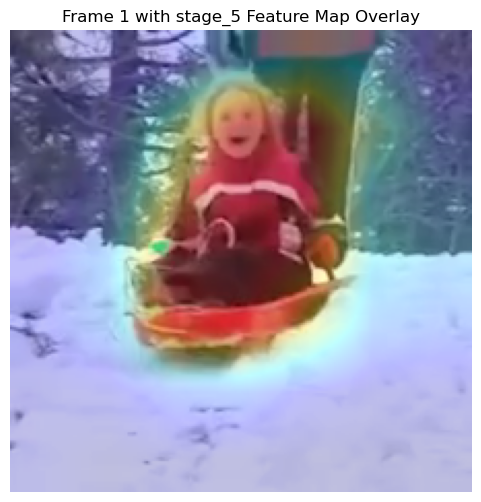

In [19]:
plot_frame_with_feature_map_overlay('0004', 1, 'stage_5', models, 'avg')